This algorithm is a simple mean-reversion trading strategy using Bollinger Bands.

**Retrieve Minute-by-Minute Historical Price Data**
- The code retrieves minute-by-minute historical price data for the 'SPY' (S&P 500 ETF) stock from Yahoo Finance for the specified date range ('2023-07-10' to '2023-07-14') with a granularity of 1 minute.

**Calculate Bollinger Bands**
- Bollinger Bands consist of three lines: the middle band (simple moving average), upper band (middle band + standard deviation * rolling standard deviation), and lower band (middle band - standard deviation * rolling standard deviation).
- The code calculates the middle band using a rolling window of 15 minutes and standard deviation of 2.

**Implement the Trading Strategy**
- The 'Signal' column is initialized to 0, representing a "Hold" state.
- If the closing price falls below the lower Bollinger Band and the previous closing price is above the previous lower Bollinger Band, a "Buy" signal is generated.
- If there's an active "Buy" position, the algorithm checks if the closing price exceeds the entry price plus a profit target of $0.40. If so, a "Sell" signal is generated.
- The 'trades' list is populated with tuples containing trade information (e.g., Buy/Sell, date, price).

**Backtest the Trading Strategy**
- The algorithm starts with a starting balance of $100,000 and simulates the trades based on the generated signals.
- For each trade, it buys shares if the signal is "Buy" and calculates the profit/loss if the signal is "Sell."
- The algorithm keeps track of the total return, number of trades, and number of winning and losing trades.

**Print Performance Metrics**
- The algorithm prints various performance metrics, including the starting date, final portfolio value, total return, number of trades, and average return per trade.

The strategy aims to take advantage of mean-reversion, buying when the price falls below the lower Bollinger Band and selling when the price exceeds a specified profit target. It's important to note that this is a simple trading strategy and may not be suitable for actual trading without further optimization and risk management. Additionally, past performance does not guarantee future results, and careful analysis and testing are required before using any trading strategy in a live trading environment.

In [33]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Retrieve Minute-by-Minute Historical Price Data (using 1-minute granularity)
symbol = 'SPY'
start_date = '2023-07-10'
end_date = '2023-07-14'
data = yf.download(symbol, start=start_date, end=end_date, interval='1m')

# Step 2: Calculate Bollinger Bands
window = 15
std_dev = 2

data['Middle Band'] = data['Close'].rolling(window=window).mean()
data['Upper Band'] = data['Middle Band'] + std_dev * data['Close'].rolling(window=window).std()
data['Lower Band'] = data['Middle Band'] - std_dev * data['Close'].rolling(window=window).std()

# Step 3: Implement the Trading Strategy
data['Signal'] = 0  # 0: Hold, 1: Buy, -1: Sell

stop_loss_percentage = 0.02  # 2% stop loss
profit_target = 0.4  # $0.40 profit target

entry_price = None
trades = []

for i in range(1, len(data)):
    if data['Close'].iloc[i] < data['Lower Band'].iloc[i]:  # Buy signal
        if data['Close'].iloc[i - 1] >= data['Lower Band'].iloc[i - 1]:
            data.loc[data.index[i], 'Signal'] = 1  # Buy
            entry_price = data['Close'].iloc[i]  # Set entry price when a buy signal is generated
            trades.append(('Buy', data.index[i], entry_price))
    elif entry_price is not None and data['Close'].iloc[i] > entry_price + profit_target:  # Sell signal
        data.loc[data.index[i], 'Signal'] = -1  # Sell
        sell_price = data['Close'].iloc[i]
        trades.append(('Sell', data.index[i], sell_price))
        entry_price = None  # Reset entry price after selling

# Step 4: Backtest the Trading Strategy
starting_balance = 100000
balance = starting_balance
shares = 0
total_return_per_trade = 0
num_winning_trades = 0
num_losing_trades = 0

for i in range(1, len(trades)):
    trade = trades[i]
    prev_trade = trades[i - 1]

    if trade[0] == 'Buy':
        shares_to_buy = int(balance / trade[2])
        shares += shares_to_buy
        balance -= shares_to_buy * trade[2]
    elif trade[0] == 'Sell':
        balance += shares * trade[2]
        total_return_per_trade += (trade[2] - prev_trade[2]) / prev_trade[2]  # Calculate profit per trade
        shares = 0
        if trade[2] > prev_trade[2]:
            num_winning_trades += 1
        else:
            num_losing_trades += 1

final_portfolio_value = balance + shares * data['Close'].iloc[-1]
total_return = (final_portfolio_value - starting_balance) / starting_balance
num_trades = len(trades)

average_return_per_trade = total_return_per_trade / num_trades if num_trades > 0 else 0

# Step 5: Print Performance Metrics
print(f'Starting Date: {start_date}')
print(f'Final Portfolio Value on {end_date}: ${final_portfolio_value:.2f}')
print(f'Total Return: {total_return:.2%}')
print(f'Number of Trades: {num_trades}')
print(f'Average Return per Trade: {average_return_per_trade:.2%}')


[*********************100%***********************]  1 of 1 completed
Starting Date: 2023-07-10
Final Portfolio Value on 2023-07-14: $101288.81
Total Return: 1.29%
Number of Trades: 66
Average Return per Trade: 0.04%


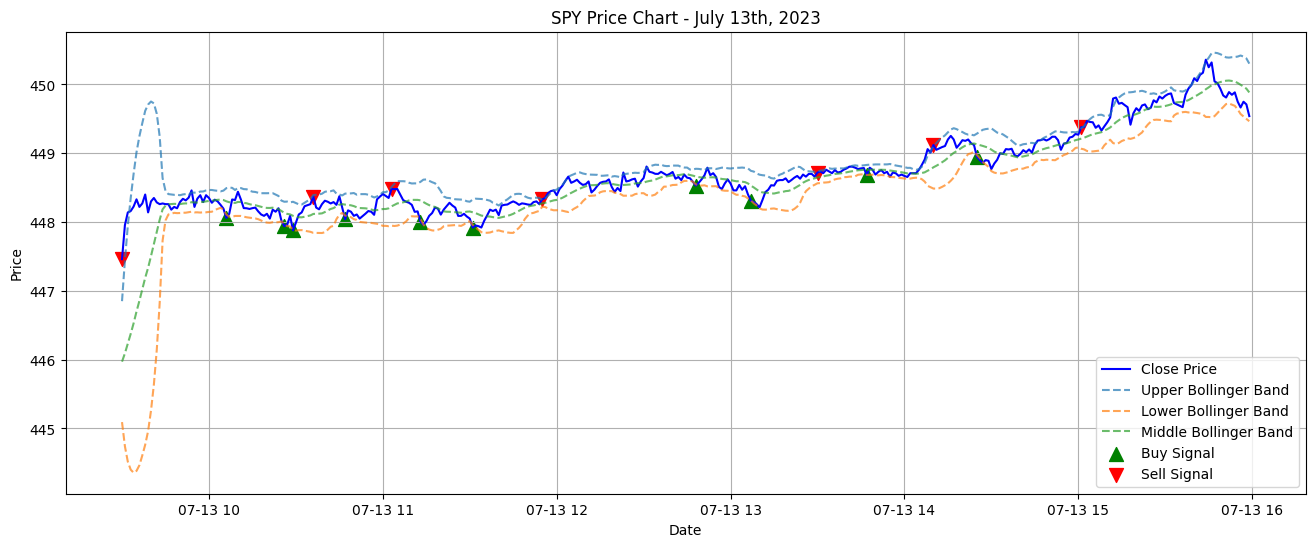

In [34]:
# Step 4: Plot the Data and Signals for June 30th, 2023
start_date_plot = "2023-07-13"
end_date_plot = "2023-07-13"
plt.figure(figsize=(16, 6))
plt.plot(data["Close"].loc[start_date_plot:end_date_plot], label="Close Price", color='b')
plt.plot(data["Upper Band"].loc[start_date_plot:end_date_plot], label="Upper Bollinger Band", linestyle="--", alpha=0.7)
plt.plot(data["Lower Band"].loc[start_date_plot:end_date_plot], label="Lower Bollinger Band", linestyle="--", alpha=0.7)
plt.plot(data["Middle Band"].loc[start_date_plot:end_date_plot], label="Middle Bollinger Band", linestyle="--", alpha=0.7)

# Plot buy and sell signals
buy_signals = data[data["Signal"] == 1].loc[start_date_plot:end_date_plot]
sell_signals = data[data["Signal"] == -1].loc[start_date_plot:end_date_plot]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="g", label="Buy Signal", s=100)
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="r", label="Sell Signal", s=100)

plt.title(f"{symbol} Price Chart - July 13th, 2023")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

